In [10]:
import pandas as pd
import openpyxl
from pypfopt import expected_returns
from pypfopt import risk_models
import seaborn as sns
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, plotting, black_litterman
from pypfopt.black_litterman import BlackLittermanModel
import numpy as np
import copy

## Collecting and Preprocessing Data for Portfolio

My sample portfolio is very tech heavy, consisting of major companies. The data was extracted from Kaggle.

In [2]:
tickers = ['AMZN', 'GOOGL', 'IBM', 'META', 'MSFT', 'NVDA', 'AAPL']
Original_weights = pd.Series({'AMZN':0.12, 'GOOGL':0.16, 'IBM':0.04, 'META':0.27, 'MSFT':0.19, 'NVDA':0.19, 'AAPL': 0.03})

# NVDA = Date (Jan 1999 - Feb 2025), Adj Close, Close, High, Low, Open, Volume
# META = Date (May 2012 - Jan 2025), Open, High, Low, Close, Adj Close, Volume
# GOOGL = Date (Aug 2004 - Dec 2024), Open, High, Low, Close, Adj Close, Volume
# AMZN = Date (Jan 2000 - Feb 2025), Open, High, Low, Close, Adj Close, Volume
# IBM = Date (Jan 1980 - Jul 2025), Open, High, Low, Close, Adj Close, Volume, Dividends, Stock Splits, Adj Factor
# MSFT = Date (Mar 1986 - Feb 2025), Open, High, Low, Close, Adj Close, Volume
# AAPL = Date (Dec 1980 - Jan 2025), Adj Close, Close, High, Low, Open, Volume

Train_Start_Date = '2012-05-18'
Train_End_Date = '2023-05-18'
Test_Start_Date = '2023-05-19'
Test_End_Date = '2024-12-17'

Portfolio = []
for tick in tickers:
    stock = pd.read_csv(f'Data/{tick}.csv')

    if tick == 'AMZN':
        stock = stock.rename(columns={'date':'Date', 'adj_close':'Adj Close'}) #Renaming date to Date
        stock['Date'] = (pd.to_datetime(stock['Date'], utc=True)).dt.date #Turning to required format
    
    if tick == 'IBM':
        stock = stock.drop(labels=['Dividends', 'Stock Splits', 'Adj Factor'], axis=1)#Dropping unecessary columns

    if tick == 'AAPL':
        stock = stock.rename(columns={'Unnamed: 0':'Date'})

    stock = stock.rename(columns={col: f"{tick}.{col}" for col in stock.columns if col != 'Date'}) #renaming with stock prefix
        
    stock['Date'] = pd.to_datetime(stock['Date'], format='%Y-%m-%d')
    
    stock = stock.loc[(stock['Date'] >= Train_Start_Date) & (stock['Date'] <= Test_End_Date)] #Filtering by overlapping dates

    stock.set_index('Date', inplace=True) #Use date as index
    
    Portfolio.append(stock)

Stock_Data = pd.concat(Portfolio, axis=1)

In [3]:
Train_Stock_Data = Stock_Data[Train_Start_Date:Train_End_Date]
Test_Stock_Data = Stock_Data[Test_Start_Date:]

print(Stock_Data)

             AMZN.open   AMZN.high    AMZN.low  AMZN.close  AMZN.Adj Close  \
Date                                                                         
2012-05-18   10.970500   10.981500   10.640500   10.692500       10.692500   
2012-05-21   10.701500   10.999000   10.641000   10.905500       10.905500   
2012-05-22   10.915500   10.943500   10.698000   10.766500       10.766500   
2012-05-23   10.735500   10.877500   10.559000   10.864000       10.864000   
2012-05-24   10.849000   10.883000   10.635000   10.762000       10.762000   
...                ...         ...         ...         ...             ...   
2024-12-11  226.410004  231.199997  226.259995  230.259995      230.259995   
2024-12-12  229.830002  231.089996  227.630005  228.970001      228.970001   
2024-12-13  228.399994  230.199997  225.860001  227.460007      227.460007   
2024-12-16  230.229996  233.000000  228.009995  232.929993      232.929993   
2024-12-17  232.389999  232.729996  227.850006  231.149994      

# Mean-Variance Portfolio Optimisation

Using exponentially weighted mean historical returns for expected returns calculation, this is similar to mean historical returns, except it gives exponentially more weight to recent prices. This is useful because it is likely the case that an asset's most recent returns hold more weight than returns from 10 years ago when it comes to estimating future returns.

The covariance matrix encodes not just the volatility of an asset, but also how it correlated to other assets. This is important because in order to reap the benefits of diversification (and thus increase return per unit risk), the assets in the portfolio should be as uncorrelated as possible. For this implementation we will use exponential covariance: an improvement over sample covariance that gives more weight to recent data.


Exponentially Weighted Mean Historical Returns:
 AMZN.EWMHR     0.244577
GOOGL.EWMHR    0.210887
IBM.EWMHR      0.007342
META.EWMHR     0.185147
MSFT.EWMHR     0.267116
NVDA.EWMHR     0.539707
AAPL.EWMHR     0.242749
dtype: float64


Exponential Coveriance Matrix:
            AMZN     GOOGL       IBM      META      MSFT      NVDA      AAPL
AMZN   0.161571  0.098322  0.023166  0.129110  0.087803  0.113373  0.068835
GOOGL  0.098322  0.127709  0.021791  0.125243  0.077419  0.095772  0.067945
IBM    0.023166  0.021791  0.040105  0.022012  0.019828  0.031039  0.025899
META   0.129110  0.125243  0.022012  0.303740  0.097230  0.127495  0.086847
MSFT   0.087803  0.077419  0.019828  0.097230  0.097215  0.104562  0.060508
NVDA   0.113373  0.095772  0.031039  0.127495  0.104562  0.266486  0.091832
AAPL   0.068835  0.067945  0.025899  0.086847  0.060508  0.091832  0.079427




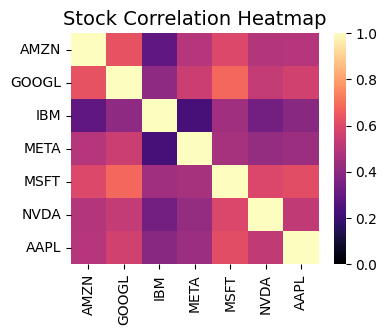

In [4]:
Subset_Adj_Close = ['AMZN.Adj Close', 'GOOGL.Adj Close', 'IBM.Adj Close', 'META.Adj Close', 'MSFT.Adj Close', 'NVDA.Adj Close', 'AAPL.Adj Close']
EWM_Returns_List = []

Exp_Cov_Matrix = (risk_models.exp_cov(Train_Stock_Data[Subset_Adj_Close]))
Train_Perc_Change_Stock = Train_Stock_Data[Subset_Adj_Close].pct_change()
Test_Perc_Change_Stock = Test_Stock_Data[Subset_Adj_Close].pct_change()

#Mostly renaming
for tick in tickers:
    EWMR_Stock = (expected_returns.mean_historical_return(Train_Stock_Data[[f'{tick}.Adj Close']]))
    EWMR_Stock = EWMR_Stock.rename({f'{tick}.Adj Close':f'{tick}.EWMHR'})
    EWM_Returns_List.append(EWMR_Stock)

    Exp_Cov_Matrix = Exp_Cov_Matrix.rename({f'{tick}.Adj Close':f'{tick}'}, axis=1)
    Exp_Cov_Matrix = Exp_Cov_Matrix.rename({f'{tick}.Adj Close':f'{tick}'}, axis=0)

    Train_Perc_Change_Stock = Train_Perc_Change_Stock.rename({f'{tick}.Adj Close':f'{tick}'}, axis=1)
    Train_Perc_Change_Stock = Train_Perc_Change_Stock.rename({f'{tick}.Adj Close':f'{tick}'}, axis=0)
    Test_Perc_Change_Stock = Test_Perc_Change_Stock.rename({f'{tick}.Adj Close':f'{tick}'}, axis=1)
    Test_Perc_Change_Stock = Test_Perc_Change_Stock.rename({f'{tick}.Adj Close':f'{tick}'}, axis=0)
    


EWM_Returns = pd.concat(EWM_Returns_List, axis=0)
print("Exponentially Weighted Mean Historical Returns:\n", EWM_Returns)
print("\n")


print("Exponential Coveriance Matrix:\n", Exp_Cov_Matrix)
print("\n")

corr_matrix = Train_Perc_Change_Stock.corr()

plt.figure(figsize=(4,3))
sns.heatmap(corr_matrix, cmap="magma", vmin=0, vmax=1, annot=False, cbar=True)

plt.title("Stock Correlation Heatmap", fontsize=14)
plt.show()

#

Sharpe Ratio = Risk-adjusted return rate, i.e: Per unit of risk how much return are we getting?


Efficient Frontier = A curve that demonstrates the best portfolios for different levels of risk.

In [5]:
Max_Sharpe_Weights = pd.Series(EfficientFrontier(EWM_Returns, Exp_Cov_Matrix).max_sharpe())
Min_Volatility_Weights = pd.Series(EfficientFrontier(EWM_Returns, Exp_Cov_Matrix).min_volatility())

for tick in tickers:
    Max_Sharpe_Weights = Max_Sharpe_Weights.rename({f'{tick}.EWMHR':f'{tick}'})
    Min_Volatility_Weights = Min_Volatility_Weights.rename({f'{tick}.EWMHR':f'{tick}'})

print("Original Weights:\n", Original_weights)
print("\n")
print("Max Sharpe Weights:\n", Max_Sharpe_Weights)
print("\n")
print("Min Volatility Weights:\n", Min_Volatility_Weights)



Original Weights:
 AMZN     0.12
GOOGL    0.16
IBM      0.04
META     0.27
MSFT     0.19
NVDA     0.19
AAPL     0.03
dtype: float64


Max Sharpe Weights:
 AMZN     0.000000
GOOGL    0.000000
IBM      0.000000
META     0.000000
MSFT     0.202826
NVDA     0.500742
AAPL     0.296432
dtype: float64


Min Volatility Weights:
 AMZN     0.000000
GOOGL    0.021251
IBM      0.758739
META     0.000000
MSFT     0.154024
NVDA     0.000000
AAPL     0.065986
dtype: float64


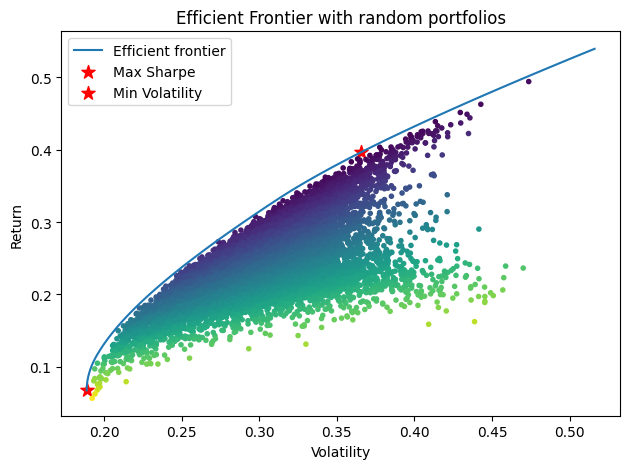

In [6]:
# Plot efficient frontier
ef = EfficientFrontier(EWM_Returns, Exp_Cov_Matrix)

fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
ef_min_volatility = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

ef_min_volatility.min_volatility()
ret_tangent, std_tangent, _ = ef_min_volatility.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

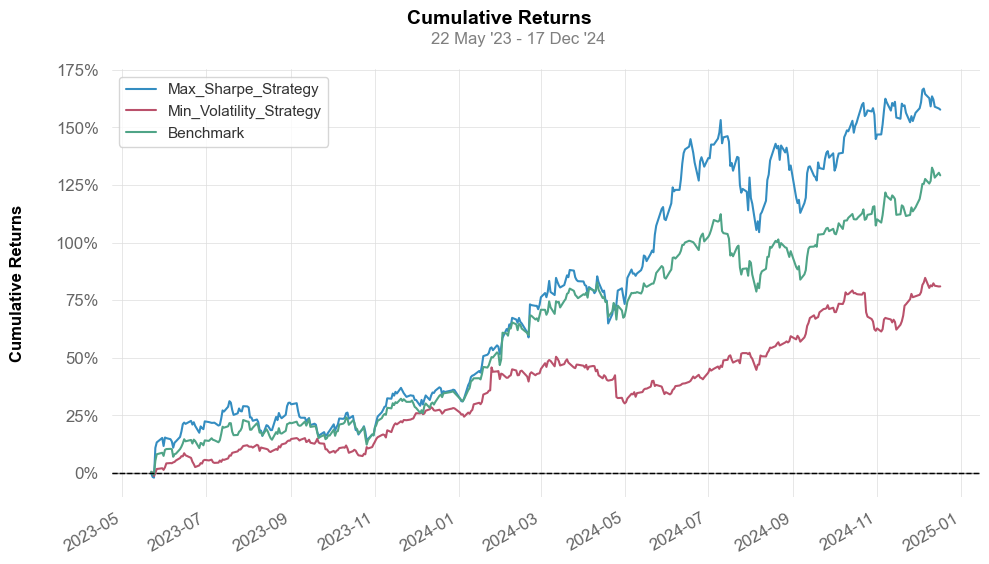

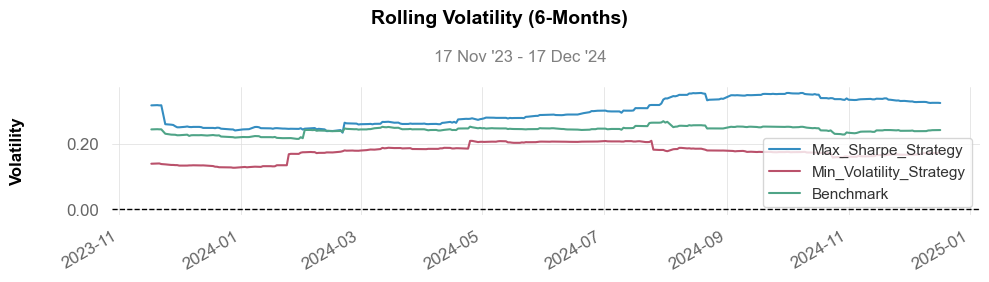

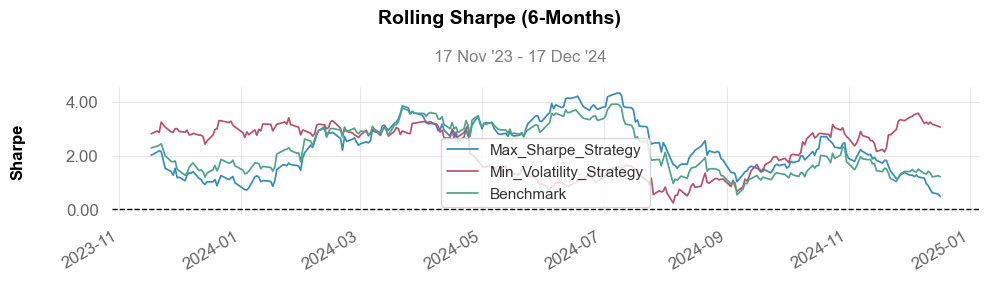

In [7]:
import quantstats as qs

#Create returns dataframe for each stock
Test_Returns = Test_Perc_Change_Stock.dropna()

# Apply weights to daily returns
actual_portfolio_returns = Test_Returns.dot(Original_weights)
optimized_Max_Sharpe_portfolio_returns = Test_Returns.dot(Max_Sharpe_Weights)
optimized_Min_Volatility_portfolio_returns = Test_Returns.dot(Min_Volatility_Weights)

combined_returns = pd.DataFrame({'Max_Sharpe_Strategy': optimized_Max_Sharpe_portfolio_returns,'Min_Volatility_Strategy':optimized_Min_Volatility_portfolio_returns, 'Benchmark': actual_portfolio_returns})


qs.plots.returns(combined_returns)
qs.plots.rolling_volatility(combined_returns)
qs.plots.rolling_sharpe(combined_returns)

# Black-Litterman Portfolio Optimisation

The Black-Litterman (BL) model takes a Bayesian approach to asset allocation. Specifically, it combines a prior estimate of returns (for example, the market-implied returns) with views on certain assets, to produce a posterior estimate of expected returns. 

The advantages of this are:

- You can provide views on only a subset of assets and BL will meaningfully propagate it, taking into account the covariance with other assets.
- You can provide confidence in your views.
- Using Black-Litterman posterior returns results in much more stable portfolios than using mean-historical return.

In [36]:
import yfinance as yf

# Download SPY data for the same period train data
spy_data = yf.download('SPY', start=Train_Start_Date, end=Train_End_Date)['Close']

/var/folders/my/zrmpls2j4pg590wwt1xktv0c0000gn/T/ipykernel_3679/2002629432.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download('SPY', start=Train_Start_Date, end=Train_End_Date)['Close']
[*********************100%***********************]  1 of 1 completed


Original Weights:
 AMZN     0.12
GOOGL    0.16
IBM      0.04
META     0.27
MSFT     0.19
NVDA     0.19
AAPL     0.03
dtype: float64


Max Sharpe Weights:
 AMZN     0.295431
GOOGL    0.000000
IBM      0.035317
META     0.200114
MSFT     0.000000
NVDA     0.469138
AAPL     0.000000
dtype: float64


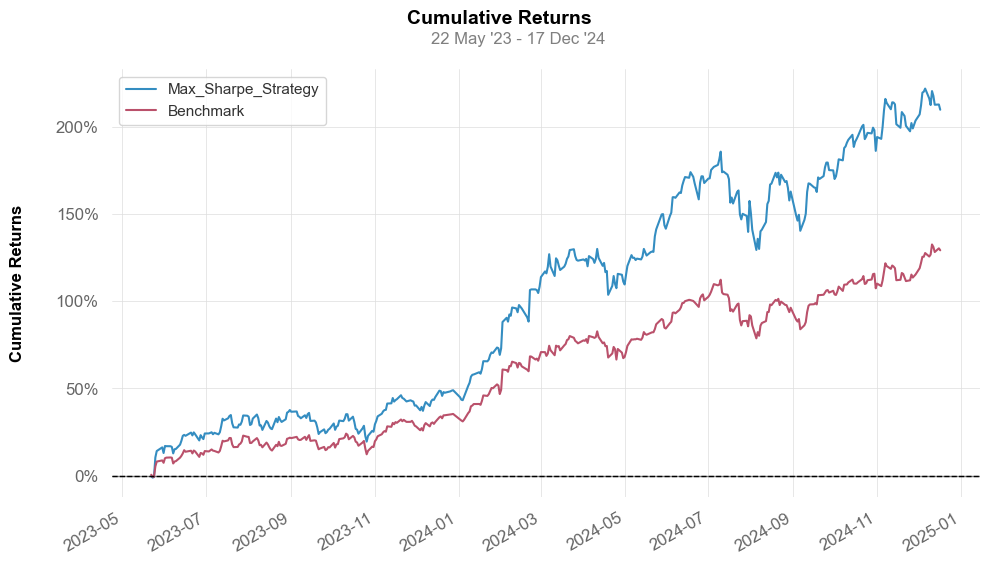

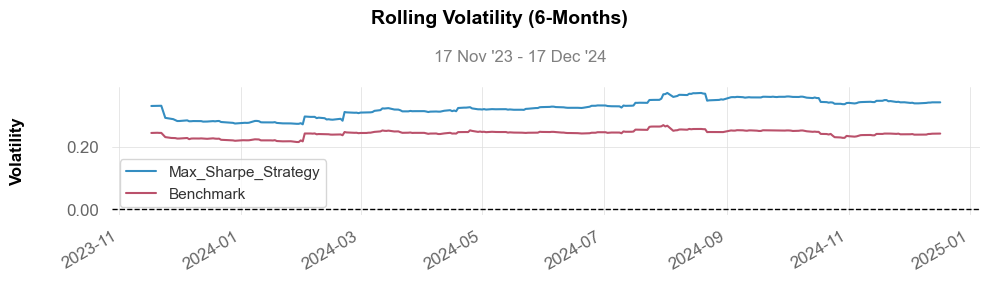

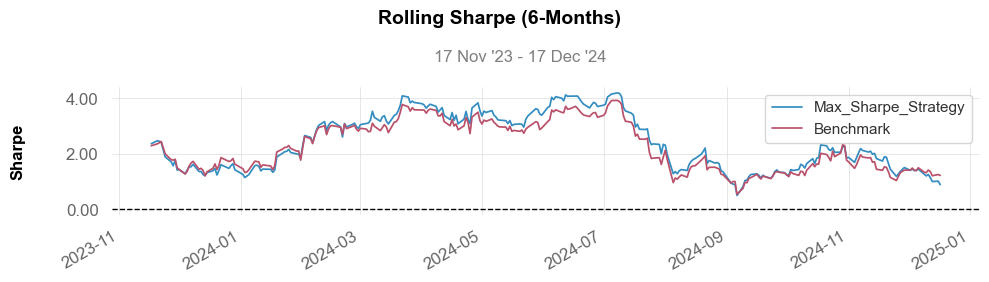

In [59]:
market_caps = {"AMZN": 1.808e12, "GOOGL": 1.909e12, "IBM": 167.99e9, "META": 1.374e12, "MSFT": 2.789e12 , "NVDA":3.146e12 , "AAPL":2.551e12}
#Market_caps is the total number of avaialble shares (given out to shareholders) multiplied by the price per share.

# Calculate market implied risk aversion which represents how much extra return investors collectively demand for taking on additional risk
delta = black_litterman.market_implied_risk_aversion(spy_data)
#e.g: delta=4 means investors want 4% extra return for 1% of variance

#Using market implied risk aversion we can calculate our prior returns
prior = black_litterman.market_implied_prior_returns(market_caps, delta, Exp_Cov_Matrix)

# Views:
# 1. NVDA will slow down (assuming -5% absolute return)
# 2. META outperforms GOOGL (assuming by 6%)  
# 3. AMZN will return 14%
# 4. GOOGL will return 4%

Q = np.array([
    [-0.05],  # NVDA slowing down (negative return)
    [0.06],   # META outperforms GOOGL by 6%
    [0.14],   # AMZN returns 14%
    [0.04]    # GOOGL returns 4%
]).reshape(-1, 1)

P = np.array([
    [0, 0, 0, 0, 0, 0, 1],     # View 1: NVDA (absolute)
    [0, 0, -1, 0, 1, 0, 0],    # View 2: META - GOOGL (relative)
    [0, 1, 0, 0, 0, 0, 0],     # View 3: AMZN (absolute)
    [0, 0, 1, 0, 0, 0, 0]      # View 4: GOOGL (absolute)
])

bl = BlackLittermanModel(cov_matrix = Exp_Cov_Matrix, pi = prior, Q=Q, P=P)

mu_bl = bl.bl_returns()   # posterior expected returns

BL_Max_Sharpe_Weights =  pd.Series(EfficientFrontier(mu_bl, Exp_Cov_Matrix).max_sharpe())
#There is no reason to do a min_volatility strategy here as it will produce the same weights as the MVO min_volatility.
#It produces the same weights because the min_volatility optimisation problem only uses the covariance and not returns.

print("Original Weights:\n", Original_weights)
print("\n")
print("Max Sharpe Weights:\n", BL_Max_Sharpe_Weights)

BL_optimized_Max_Sharpe_portfolio_returns = Test_Returns.dot(BL_Max_Sharpe_Weights)
BL_optimized_Min_Volatility_portfolio_returns = Test_Returns.dot(BL_Min_Volatility_Weights)

combined_returns = pd.DataFrame({'Max_Sharpe_Strategy': BL_optimized_Max_Sharpe_portfolio_returns, 'Benchmark': actual_portfolio_returns})


qs.plots.returns(combined_returns)
qs.plots.rolling_volatility(combined_returns)
qs.plots.rolling_sharpe(combined_returns)

## Comparing the Strategies

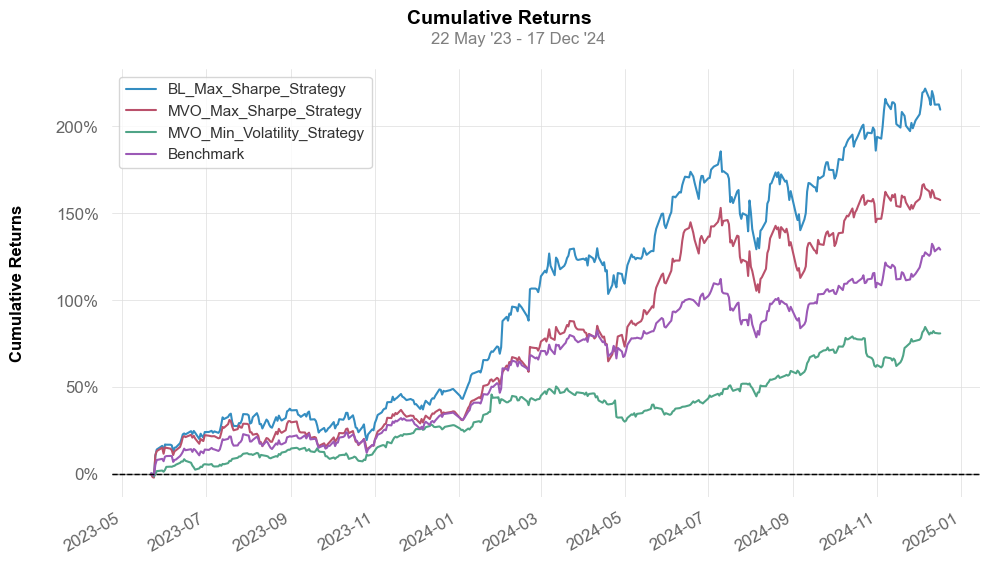

In [61]:
combined_returns = pd.DataFrame({'BL_Max_Sharpe_Strategy': BL_optimized_Max_Sharpe_portfolio_returns,'MVO_Max_Sharpe_Strategy':optimized_Max_Sharpe_portfolio_returns, 'MVO_Min_Volatility_Strategy': optimized_Min_Volatility_portfolio_returns, 'Benchmark': actual_portfolio_returns})
qs.plots.returns(combined_returns)